# Sequential Computation with jax.lax.scan

## Introduction

Python while having a very simple and intuitive syntax is generally not performant out of the box, esspecially with regard to control flows like loops and conditionals. [JAX](https://docs.jax.dev/en/latest/index.html) provides simple API's and functional transformations to make python more performant while keeping the simple syntax. Specifically, what we will be looking into today is the [jax.lax.scan](https://docs.jax.dev/en/latest/_autosummary/jax.lax.scan.html), which I will call *scan* for short. 

## What is *scan* good for?

In the simulation of dynamical systems, for example, we are confronted with the situation of moving the coordinates through time using the rules given by some differential or difference equation. For reasons we will see late, I will call this carry. We are looking to carry inital coordinates through time. But just moving these coordinates is not really the point. We want to know store the trajectory over time, which requires us to store these coordinates, or the carry, for every timestep in the simulation. This is type of problem that *scan* is suited for.

## Solution with Numpy and JNP

But before we discuss the usage of *scan*, let us discuss a simple solution to this problem. We can define some stepper, a function that takes in coordinates at the current timestep and returns the coordinates at the next timestep. We could then define a variable called trajectory and append to this at each iteration in the loop. Finally, we just set the next coordinates that have been returned as the coordinates. It would look something like this for the Lorenz system:

In [1]:
#IGNORE
import time
import matplotlib.pyplot as plt
plt.style.use("ggplot")


def plot_trajectory(trajectory, init_coords, heading="Lorenz System"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Extract x, y, z coordinates
    x, y, z = zip(*trajectory)

    ax.plot(x, y, z, lw=0.25, color="blue", label="Trajectory")
    ax.scatter(*init_coords, marker='x', label="Initial Coordinates")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(heading)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [2]:
import numpy as np

class LorenzRK4StepperNP:
    def __init__(self, sigma=10., rho=28., beta=8/3, tau=0.01):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.tau = tau

    def __call__(self, coords):

        def lorenz_rhs(coords, sigma=self.sigma, rho=self.rho, beta=self.beta):
            return np.array(
                [
                    sigma * (coords[1] - coords[0]),
                    coords[0] * (rho - coords[2]) - coords[1],
                    coords[0] * coords[1] - beta * coords[2],
                ]
            )
        
        k_1 = self.tau * lorenz_rhs(coords)
        k_2 = self.tau * lorenz_rhs(coords + (1 / 2) * k_1)
        k_3 = self.tau * lorenz_rhs(coords + (1 / 2) * k_2)
        k_4 = self.tau * lorenz_rhs(coords + k_3)

        new_coords = coords + (1 / 6) * (k_1 + 2 * k_2 + 2 * k_3 + k_4)

        return new_coords


def rollout_loop(stepper, init_coords, length):
    coords = init_coords
    traj = [init_coords]

    for _ in range(length):
        coords = stepper(coords)
        traj.append(coords)

    return traj

sigma=10.
rho=28.
beta=8/3
tau = 0.01
stepper_np = LorenzRK4StepperNP(sigma, rho, beta, tau)

init_coords = np.full((3,), 10)

final_time = 100
length=int(final_time / tau)

%timeit rollout_loop(stepper_np, init_coords, length)

93.3 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


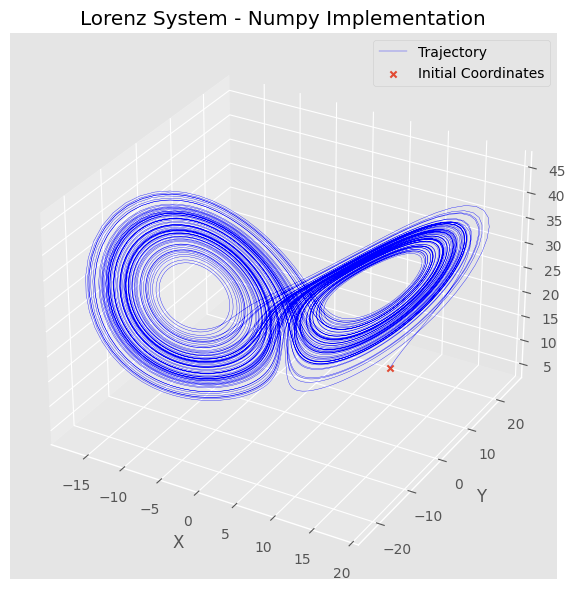

In [ ]:
#IGNORE
trajectory_np = rollout_loop(stepper_np, init_coords, length)
plot_trajectory(trajectory_np, init_coords, "Lorenz System - Numpy Implementation")

This is a perfectly valid solution to this problem. The issue is that as we make the final time larger, or increase the number of initial conditions, a loop based approach like this will not scale well. We will need to implement some vectorised and compiled function in order to speed up the computation. This is where JAX can help. While, JAX provides an almost identical API to Numpy, via [jax.numpy](https://docs.jax.dev/en/latest/jax.numpy.html#module-jax.numpy) we need to be careful. A simple drop in replacement **does not** always speed up computation.

In [4]:
import jax.numpy as jnp

class LorenzRK4StepperJNP:
    def __init__(self, sigma=10.0, rho=28.0, beta=8 / 3, tau=0.01):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.tau = tau

    def __call__(self, coords):
        def lorenz_rhs(coords, sigma=self.sigma, rho=self.rho, beta=self.beta):
            return jnp.array(
                [
                    sigma * (coords[1] - coords[0]),
                    coords[0] * (rho - coords[2]) - coords[1],
                    coords[0] * coords[1] - beta * coords[2],
                ]
            )

        k_1 = self.tau * lorenz_rhs(coords)
        k_2 = self.tau * lorenz_rhs(coords + (1 / 2) * k_1)
        k_3 = self.tau * lorenz_rhs(coords + (1 / 2) * k_2)
        k_4 = self.tau * lorenz_rhs(coords + k_3)

        new_coords = coords + (1 / 6) * (k_1 + 2 * k_2 + 2 * k_3 + k_4)

        return new_coords

stepper_jnp = LorenzRK4StepperJNP(sigma, rho, beta, tau)

init_coords = jnp.full((3,), 10)
length = int(final_time / tau)

%timeit rollout_loop(stepper_jnp, init_coords, length)

18 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


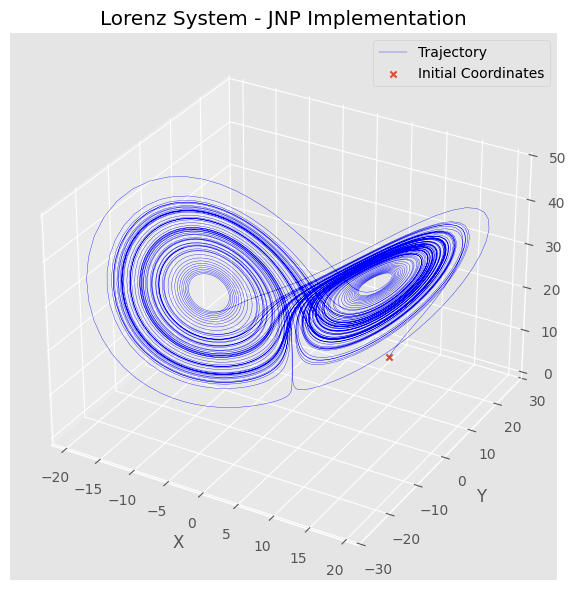

In [5]:
#IGNORE
trajectory_jnp = rollout_loop(stepper_jnp, init_coords, length)
plot_trajectory(trajectory_jnp, init_coords, "Lorenz System - JNP Implementation")

We can see that qualitatively, the Lorenz plots are produced are the same. I say qualitatively sice we can see that there is a lonely single paths along the outside of the butterfly shape in the jax implementation, but none in the numpy. This is simply due to the fact that numpy uses double precision and jax uses single precision by default. Since this system is chaotic, a small difference in implementation like this will produce different results.

The other difference is that the jax implementation takes significantly longer. But as I said, this is a faily naïve translation of simple method. We will be able to speed this up significantly using the *scan* functional. 

## Using *scan*

*scan* takes in four main arguments that pertain to us.
1. **f**: This is a function that is used to move the system, kind of like the stepper method called in the body of the loop, however this method needs to have a very specific signature which we will discuss in a little bit.
2. **init**: These are the initial conditions that will be passed into the funtion **f**.
3. **xs**: Again, this is an array that will be passed to the function **f** during each iteration, this is used for some external force, like the control or action in a reinforcement learning problem.
4. **length**: The number of iterations that will be run.

That is a lot of information but I think it will all makes sense if we look at what a vanilla python implementation of the *scan* function would be:
```python
def scan(f, init, xs, length=None):
  if xs is None:
    xs = [None] * length
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```

First off, we can see what the specific signature of the function **f** is. It is a function that takes in carry in its first argument. This is why I used carry to mean coordinates earlier, and it also takes in an **x** from the **xs**. In the loop, we can see that carry is passed again to the function, and the other output of the function is appended to a list, **y**, which is then stacked and returned after execution. Thus, **f** must take two arguments, and return two values. The first will be the coordinates to carry to the step step, and if we make the second the coordinates as well, we will get the coordinates stacked in the second position on the return of *scan*. The stacked history of the coordinates is just the trajectory the initial conditions have taken. Let us adjust our stepper to confirm to what is needed for **f** and adjust the rollout to use *scan*. 

In [6]:
import jax 

def rollout_scan(stepper):

    def scan_fn(coords, _):
        new_coords = stepper(coords)
        return new_coords, new_coords
    
    def rollout_fn(init_coords, length):
        _, trajectory = jax.lax.scan(scan_fn, init_coords, None, length)

        return trajectory

    return rollout_fn

%timeit rollout_scan(stepper_jnp)(init_coords, length).block_until_ready()

54.1 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


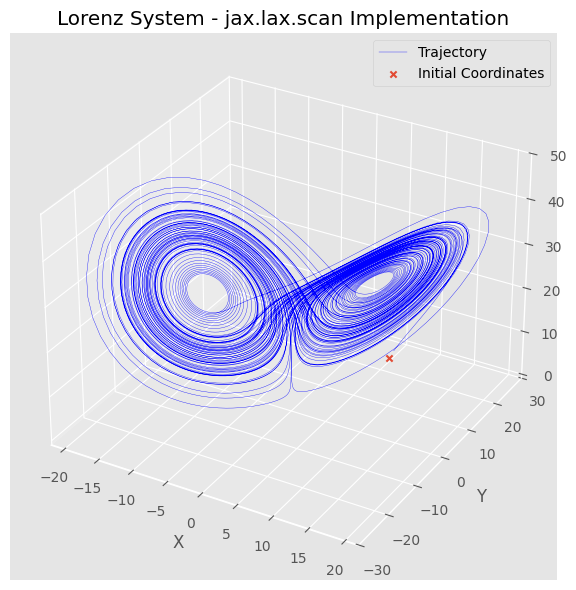

In [10]:
#IGNORE
trajectory_scan = rollout_scan(stepper_jnp)(init_coords, length)
plot_trajectory(trajectory_scan, init_coords, "Lorenz System - jax.lax.scan Implementation")

Already, over such a small final time we can see that the rollout_scan has halved the execution time, while still, qualitatively, we still have the same butterfly shape. Let now comapre the execution time for our *scan* implementation, comapred with the numpy.

In [ ]:
#IGNORE
lengths = [100, 1_000, 10_000, 100_000, 1_000_000]
log10_lengths = np.log10(lengths)

init_coords_np = np.full((3,), 10)
init_coords_jnp = jnp.full((3,), 10)

execution_times_np = []
execution_times_scan = []

for length in lengths:
    start_time = time.perf_counter()
    rollout_loop(stepper_np, init_coords_np, length)
    end_time = time.perf_counter()
    execution_times_np.append(end_time - start_time)

for length in lengths:
    start_time = time.perf_counter()
    rollout_scan(stepper_jnp)(init_coords_jnp, length).block_until_ready()
    end_time = time.perf_counter()
    execution_times_scan.append(end_time - start_time)

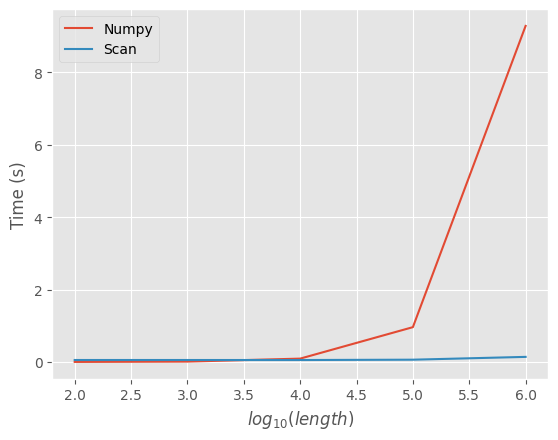

In [ ]:
#IGNORE

plt.plot(log10_lengths, execution_times_np, label="Numpy")
plt.plot(log10_lengths, execution_times_scan, label="Scan")

plt.ylabel("Time (s)")
plt.xlabel(r"$log_{10}(length)$")

plt.legend()
plt.show()


Initially, we see that the numply implementation is actually faster than the scan. But as soon as the length grows, the numpy implementation grows linearly (it loops exponential but that is just because the x-axis is the logorithm), and the jax implementation is almost constant which is just remarkable. Bare in mind that this is not being run on any special GPU, this is just a CPU but JAX can optimised this code to make it run incredibly fast. The main question is how? How can JAX do this?

To answer this, lets consider why JAX was so slow in a normal loop. At a low level, JAX converts linear algebra operations into [XLA](https://openxla.org/xla) operations. A normal python loop will be unenrolled and each operation in an interation will be a node on that graph. Naturally, this will not be very efficient since the the construction and execution of this graph can be slow is the graph is too large. The *scan* function converts the code into a singe XLA while operations which means the computation can be run incredibly fast on your processing unit.

## Conclusion

While it is obvious that this *scan* functional is not replacing loops, we may still need the indexing and small loops may be faster than *scan*. It is incredible how much faster some computations can be when they do confirm to the correct signature and situation that is required. This is just a taste of what JAX can do, even what the *scan* functional can do. What we will discuss in another post is how we can use both scan and [jax.vmap](https://docs.jax.dev/en/latest/_autosummary/jax.vmap.html) to create an incredibly fast routine to compute the maximal characteristic Lyapunov exponent in another chaotic system.